# **Methodology (Machine Learning)**
# Modelling


1. target = price
1. features = category, discount_flag, sellable_online, other_colors, designer, depth, height, width
1. further data preparation = 
    - handle outliers with caping 
    - binary encoding for categorical data
1. data splitting = 70:30
1. Hyperparameter tuning with GridSearchCV
1. Model evaluation: 
    - R2
    - RMSE
    - MAE
    - MSE
1. Model benchmark:
    - Linear regression
    - Decision tree regressor
    - Random forest regressor
    - KNN regressor

## 1. Loading Data

Libary

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, math
import statsmodels.api as sm
import pylab as pl
from numpy import log

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import PowerTransformer

import category_encoders as ce
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectPercentile

from sklearn.metrics import SCORERS, r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline

Load data

In [ ]:
df_clean = pd.read_csv('clean_ikea_data.csv')
df_clean.head()

,Unnamed: 0,item_id,name,category,price,old_price,discount,discount_flag,sellable_online,link,other_colors,description,designer,depth,height,width,volume
0,0,90420332,FREKVENS,Bar furniture,265.0,265.0,0.0,0,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,False,Bar table,Nicholai Wiig Hansen,51.0,99.0,51.0,257499.0
1,1,368814,NORDVIKEN,Bar furniture,995.0,995.0,0.0,0,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,False,Bar table,Francis Cayouette,140.0,105.0,80.0,1176000.0
2,2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,2095.0,0.0,0,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,False,Bar table and 4 bar stools,Francis Cayouette,55.0,83.0,80.0,365200.0
3,3,80155205,STIG,Bar furniture,69.0,69.0,0.0,0,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,True,Bar stool with backrest,Henrik Preutz,50.0,100.0,60.0,300000.0
4,4,30180504,NORBERG,Bar furniture,225.0,225.0,0.0,0,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,False,Wall-mounted drop-leaf table,Marcus Arvonen,60.0,43.0,74.0,190920.0


In [ ]:
df = df_clean.copy()
df = df.drop(columns = df.columns[0])

In [ ]:
df = df.drop(columns =['item_id','old_price','discount','link','name','description','volume'])

In [ ]:
df

,category,price,discount_flag,sellable_online,other_colors,designer,depth,height,width
0,Bar furniture,265.0,0,True,False,Nicholai Wiig Hansen,51.0,99.0,51.0
1,Bar furniture,995.0,0,False,False,Francis Cayouette,140.0,105.0,80.0
2,Bar furniture,2095.0,0,False,False,Francis Cayouette,55.0,83.0,80.0
3,Bar furniture,69.0,0,True,True,Henrik Preutz,50.0,100.0,60.0
4,Bar furniture,225.0,0,True,False,Marcus Arvonen,60.0,43.0,74.0
...,...,...,...,...,...,...,...,...,...
2957,Wardrobes,2045.0,0,True,False,No Designer,66.0,236.0,200.0
2958,Wardrobes,750.0,1,True,False,Ehlén Johansson,50.0,350.0,91.0
2959,Wardrobes,1572.0,1,True,False,Ehlén Johansson,50.0,350.0,135.0
2960,Wardrobes,924.0,1,True,False,Ehlén Johansson,50.0,350.0,175.0


remove outliers in price (capping method)

In [ ]:
upperLimit = df.price.mean() + 3 * df.price.std()
lowerLimit = df.price.mean() - 3 * df.price.std()

In [ ]:
df = df[(df.price < upperLimit) & (df.price > lowerLimit)]
df

,category,price,discount_flag,sellable_online,other_colors,designer,depth,height,width
0,Bar furniture,265.0,0,True,False,Nicholai Wiig Hansen,51.0,99.0,51.0
1,Bar furniture,995.0,0,False,False,Francis Cayouette,140.0,105.0,80.0
2,Bar furniture,2095.0,0,False,False,Francis Cayouette,55.0,83.0,80.0
3,Bar furniture,69.0,0,True,True,Henrik Preutz,50.0,100.0,60.0
4,Bar furniture,225.0,0,True,False,Marcus Arvonen,60.0,43.0,74.0
...,...,...,...,...,...,...,...,...,...
2957,Wardrobes,2045.0,0,True,False,No Designer,66.0,236.0,200.0
2958,Wardrobes,750.0,1,True,False,Ehlén Johansson,50.0,350.0,91.0
2959,Wardrobes,1572.0,1,True,False,Ehlén Johansson,50.0,350.0,135.0
2960,Wardrobes,924.0,1,True,False,Ehlén Johansson,50.0,350.0,175.0


In [ ]:
df = df[(df.price < upperLimit) & (df.price > lowerLimit)]
df = df.reset_index()
df = df.drop(columns = df.columns[0])

In [ ]:
df

,category,price,discount_flag,sellable_online,other_colors,designer,depth,height,width
0,Bar furniture,265.0,0,True,False,Nicholai Wiig Hansen,51.0,99.0,51.0
1,Bar furniture,995.0,0,False,False,Francis Cayouette,140.0,105.0,80.0
2,Bar furniture,2095.0,0,False,False,Francis Cayouette,55.0,83.0,80.0
3,Bar furniture,69.0,0,True,True,Henrik Preutz,50.0,100.0,60.0
4,Bar furniture,225.0,0,True,False,Marcus Arvonen,60.0,43.0,74.0
...,...,...,...,...,...,...,...,...,...
2882,Wardrobes,2045.0,0,True,False,No Designer,66.0,236.0,200.0
2883,Wardrobes,750.0,1,True,False,Ehlén Johansson,50.0,350.0,91.0
2884,Wardrobes,1572.0,1,True,False,Ehlén Johansson,50.0,350.0,135.0
2885,Wardrobes,924.0,1,True,False,Ehlén Johansson,50.0,350.0,175.0


Data description

In [ ]:
Descr =[]

for i in df.columns:
    Descr.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        df[i].nunique(),
        df[i].unique()
    ])
    
tableDescr = pd.DataFrame(Descr, columns=['column','type','nan','nunique','unique'])
tableDescr

,column,type,nan,nunique,unique
0,category,object,0,17,"[Bar furniture, Beds, Bookcases & shelving uni..."
1,price,float64,0,913,"[265.0, 995.0, 2095.0, 69.0, 225.0, 345.0, 129..."
2,discount_flag,int64,0,2,"[0, 1]"
3,sellable_online,bool,0,2,"[True, False]"
4,other_colors,bool,0,2,"[False, True]"
5,designer,object,0,83,"[Nicholai Wiig Hansen, Francis Cayouette, Henr..."
6,depth,float64,0,158,"[51.0, 140.0, 55.0, 50.0, 60.0, 45.0, 44.0, 47..."
7,height,float64,0,226,"[99.0, 105.0, 83.0, 100.0, 43.0, 91.0, 95.0, 7..."
8,width,float64,0,266,"[51.0, 80.0, 60.0, 74.0, 40.0, 50.0, 52.0, 46...."


## 2. Binary encoding

In [ ]:
# function
binaryEnc = ce.BinaryEncoder()

transformer = ColumnTransformer([                                
                                 ('cat',binaryEnc,['category']),   
                                 ('des',binaryEnc,['designer'])
                                ], remainder = 'passthrough')

# model fitting & transform
transformer_binary = transformer.fit_transform(df)

# pembuatan tabel hasil binary encoding (dr np -> pd)
data_binary = pd.DataFrame(transformer_binary)
data_binary

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,265.0,0,True,False,51.0,99.0,51.0
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,995.0,0,False,False,140.0,105.0,80.0
2,0,0,0,0,0,1,0,0,0,0,...,0,1,0,2095.0,0,False,False,55.0,83.0,80.0
3,0,0,0,0,0,1,0,0,0,0,...,0,1,1,69.0,0,True,True,50.0,100.0,60.0
4,0,0,0,0,0,1,0,0,0,0,...,1,0,0,225.0,0,True,False,60.0,43.0,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2882,0,1,0,0,0,1,0,0,0,0,...,1,1,0,2045.0,0,True,False,66.0,236.0,200.0
2883,0,1,0,0,0,1,0,0,0,0,...,0,0,0,750.0,1,True,False,50.0,350.0,91.0
2884,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1572.0,1,True,False,50.0,350.0,135.0
2885,0,1,0,0,0,1,0,0,0,0,...,0,0,0,924.0,1,True,False,50.0,350.0,175.0


Cari tahu list category dan designer 

In [ ]:
data_binary[['category','designer']] = df[['category','designer']]

listCategory = data_binary[[0,1,2,3,4,5,'category']].drop_duplicates()
listDesigner = data_binary[[6,7,8,9,10,11,12,13,'designer']].drop_duplicates()

In [ ]:
display(listCategory)
display(listDesigner)

,0,1,2,3,4,5,category
0,0,0,0,0,0,1,Bar furniture
47,0,0,0,0,1,0,Beds
243,0,0,0,0,1,1,Bookcases & shelving units
791,0,0,0,1,0,0,Cabinets & cupboards
976,0,0,0,1,0,1,Café furniture
994,0,0,0,1,1,0,Chairs
1424,0,0,0,1,1,1,Chests of drawers & drawer units
1535,0,0,1,0,0,0,Children's furniture
1619,0,0,1,0,0,1,Nursery furniture
1641,0,0,1,0,1,0,Outdoor furniture


,6,7,8,9,10,11,12,13,designer
0,0,0,0,0,0,0,0,1,Nicholai Wiig Hansen
1,0,0,0,0,0,0,1,0,Francis Cayouette
3,0,0,0,0,0,0,1,1,Henrik Preutz
4,0,0,0,0,0,1,0,0,Marcus Arvonen
5,0,0,0,0,0,1,0,1,Carina Bengs
...,...,...,...,...,...,...,...,...,...
1755,0,1,0,0,1,1,1,1,Lisel Garsveden
2201,0,1,0,1,0,0,0,0,Nada Debs
2306,0,1,0,1,0,0,0,1,Johanna Jelinek
2409,0,1,0,1,0,0,1,0,Jomi Evers


## 3. Data splitting

In [ ]:
features = ['category', 'discount_flag', 'sellable_online', 'other_colors', 'designer', 'depth','height','width'] # all variabel
x = df[features]
y = df.price

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y, 
    test_size = 0.3,
    random_state = 42
)

## 4. Fit & Transform

In [ ]:
x_train_prep = transformer.fit_transform(x_train)
x_test_prep = transformer.transform(x_test)

In [ ]:
x_train_prep = pd.DataFrame(x_train_prep)
x_test_prep = pd.DataFrame(x_test_prep)

In [ ]:
transformer.transformers_

[('cat', BinaryEncoder(), ['category']),
 ('des', BinaryEncoder(), ['designer']),
 ('remainder', 'passthrough', [1, 2, 3, 5, 6, 7])]

In [ ]:
# akses nama category
cat_var = list(transformer.transformers_[0][1].get_feature_names())

In [ ]:
# akses nama designer
des_var = list(transformer.transformers_[1][1].get_feature_names())

In [ ]:
features = cat_var + des_var + ['discount_flag', 'sellable_online', 'other_colors','depth','height','width']

In [ ]:
x_train_prep.columns = features
x_test_prep.columns = features

## 5. Model benchmark

In [ ]:
LR = LinearRegression()
DT = DecisionTreeRegressor(max_depth = 3, random_state = 42)
FR = RandomForestRegressor(n_estimators = 10, max_depth = 3, random_state = 42)
KR = KNeighborsRegressor(n_neighbors=3)

## 6. Model Selection

A. R2 <br>
B. RMSE <br>
C. MAE <br>
D. MSE

A. R-squared

In [ ]:
def r2(model):
    model.fit(x_train_prep, y_train)
    y_pred = model.predict(x_test_prep)
    print(f'hasil R2 {model}: \n{r2_score(y_test,y_pred)}\n')

used_model = [LR,DT,FR,KR]
for i in used_model:
    r2(i)

hasil R2 LinearRegression(): 
0.5862174174233697

hasil R2 DecisionTreeRegressor(max_depth=3, random_state=42): 
0.5761942890121103

hasil R2 RandomForestRegressor(max_depth=3, n_estimators=10, random_state=42): 
0.6430394064074516

hasil R2 KNeighborsRegressor(n_neighbors=3): 
0.7062709874885287



Conlc:
1. KNN Regressor nilainya paling tinggi

B. RMSE

In [ ]:
def rmse(model):
    model.fit(x_train_prep, y_train)
    y_pred = model.predict(x_test_prep)
    print(f'hasil RMSE {model}: \n{math.sqrt(mean_squared_error(y_test,y_pred))}\n')

used_model = [LR,DT,FR,KR]
for i in used_model:
    rmse(i)

hasil RMSE LinearRegression(): 
702.473888078386

hasil RMSE DecisionTreeRegressor(max_depth=3, random_state=42): 
710.9310540567874

hasil RMSE RandomForestRegressor(max_depth=3, n_estimators=10, random_state=42): 
652.4604933725035

hasil RMSE KNeighborsRegressor(n_neighbors=3): 
591.8579768186149



Conlc:
1. Error KNN Regressor paling kecil

C. MAE  

In [ ]:
def mae(model):
    model.fit(x_train_prep, y_train)
    y_pred = model.predict(x_test_prep)
    print(f'hasil MAE {model}: \n{mean_absolute_error(y_test,y_pred)}\n')

used_model = [LR,DT,FR,KR]
for i in used_model:
    mae(i)

hasil MAE LinearRegression(): 
488.3564826481403

hasil MAE DecisionTreeRegressor(max_depth=3, random_state=42): 
492.10570714024493

hasil MAE RandomForestRegressor(max_depth=3, n_estimators=10, random_state=42): 
453.1276815438484

hasil MAE KNeighborsRegressor(n_neighbors=3): 
361.26228373702423



Conlc:
1. Error KNN Regressor paling kecil

D. MSE  

In [ ]:
def mse(model):
    model.fit(x_train_prep, y_train)
    y_pred = model.predict(x_test_prep)
    print(f'hasil MSE {model}: \n{mean_squared_error(y_test,y_pred)}\n')

used_model = [LR,DT,FR,KR]
for i in used_model:
    mse(i)

hasil MSE LinearRegression(): 
764458.1640327799

hasil MSE DecisionTreeRegressor(max_depth=3, random_state=42): 
484706.6897731127

hasil MSE RandomForestRegressor(max_depth=3, n_estimators=10, random_state=42): 
477858.5536544988

hasil MSE KNeighborsRegressor(n_neighbors=3): 
560188.0437741894



Conlc:
1. Error RandomForestRegressor paling kecil

Plotting

LinearRegression()


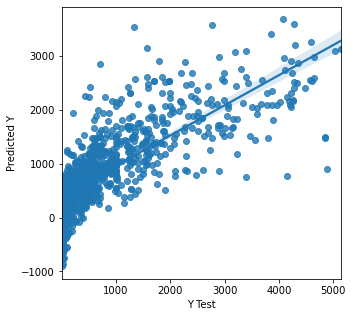

DecisionTreeRegressor(max_depth=3, random_state=42)


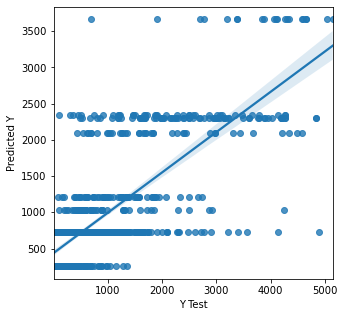

RandomForestRegressor(max_depth=3, n_estimators=10, random_state=42)


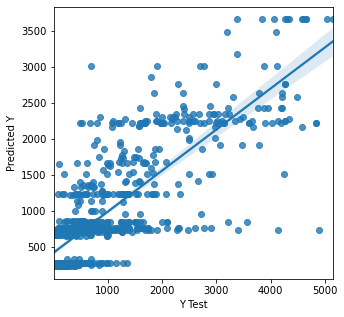

KNeighborsRegressor(n_neighbors=3)


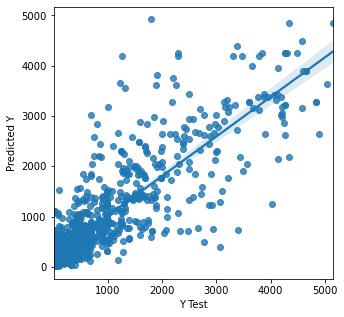

In [ ]:
def plot(model):
    model.fit(x_train_prep, y_train)
    y_pred = model.predict(x_test_prep)
    data = pd.DataFrame({'Actual':y_test, 'Prediction': y_pred})
    
    print(model)
    plt.figure(figsize=(5,5))
    sns.regplot(y_test,y_pred,fit_reg =True)
    plt.xlabel('Y Test')
    plt.ylabel('Predicted Y')
    plt.show()

used_model = [LR,DT,FR,KR]
for i in used_model:
    plot(i)
  
    

## 7. Hyperparameter Tuning

KNN Regressor

A. R2

In [ ]:
# ?KNeighborsRegressor

In [ ]:
KNN_before = KNeighborsRegressor(n_neighbors=3)

estimator = Pipeline([
                      ('preprocess',transformer),
                      ('clf',KNN_before)                 
])

hyperparam_space = {
    'clf__n_neighbors': list(range(1,21,1)), # default = 5
    'clf__weights': ['uniform', 'distance'],
    'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'clf__leaf_size': list(range(1,60,5))
}

grid_search = GridSearchCV(
    estimator, # model to tune
    param_grid = hyperparam_space, # hyperparameter space
    cv = None, # evaluation method
    scoring = 'r2', # metrics
    n_jobs = -1 # use all cores
)


In [ ]:
grid_search.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         BinaryEncoder(),
                                                                         ['category']),
                                                                        ('des',
                                                                         BinaryEncoder(),
                                                                         ['designer'])])),
                                       ('clf',
                                        KNeighborsRegressor(n_neighbors=3))]),
             n_jobs=-1,
             param_grid={'clf__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'clf__leaf_size': [1, 6, 11, 16, 21, 26

In [ ]:
print('best score',grid_search.best_score_)
print('best param',grid_search.best_params_)

best score 0.7014952087174837
best param {'clf__algorithm': 'kd_tree', 'clf__leaf_size': 26, 'clf__n_neighbors': 15, 'clf__weights': 'distance'}


B. MAE

In [ ]:
KNN_before = KNeighborsRegressor(n_neighbors=3)

estimator = Pipeline([
                      ('preprocess',transformer),
                      ('clf',KNN_before)                 
])

hyperparam_space = {
    'clf__n_neighbors': list(range(1,21,1)), # default = 5
    'clf__weights': ['uniform', 'distance'],
    'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'clf__leaf_size': list(range(1,60,5))
}

grid_search = GridSearchCV(
    estimator, # model to tune
    param_grid = hyperparam_space, # hyperparameter space
    cv = None, # evaluation method
    scoring = 'neg_mean_absolute_error', # metrics
    n_jobs = -1 # use all cores
)


In [ ]:
grid_search.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         BinaryEncoder(),
                                                                         ['category']),
                                                                        ('des',
                                                                         BinaryEncoder(),
                                                                         ['designer'])])),
                                       ('clf',
                                        KNeighborsRegressor(n_neighbors=3))]),
             n_jobs=-1,
             param_grid={'clf__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'clf__leaf_size': [1, 6, 11, 16, 21, 26

In [ ]:
print('best score',grid_search.best_score_)
print('best param',grid_search.best_params_)

best score -356.2667953677113
best param {'clf__algorithm': 'kd_tree', 'clf__leaf_size': 26, 'clf__n_neighbors': 15, 'clf__weights': 'distance'}


RandomForest Regressor

A. R2

In [ ]:
FR_before = RandomForestRegressor(n_estimators = 10, max_depth = 3, random_state = 42)
estimator = Pipeline([
                      ('preprocess',transformer),
                      ('clf',FR_before)                 
])

hyperparam_space = {
    'clf__n_estimators': list(range(20,220,20)), # default 100
    'clf__max_depth':[1,3,5,7,9,11,13,15],
    'clf__criterion':['mse','mae','squared_error','absolute_error','poisson'],
    'clf__random_state': [42]
}

grid_search = GridSearchCV(
    estimator, # model to tune
    param_grid = hyperparam_space, # hyperparameter space
    cv = None, # evaluation method
    scoring = 'r2', # metrics
    n_jobs = -1 # use all cores
)

In [ ]:
grid_search.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         BinaryEncoder(),
                                                                         ['category']),
                                                                        ('des',
                                                                         BinaryEncoder(),
                                                                         ['designer'])])),
                                       ('clf',
                                        RandomForestRegressor(max_depth=3,
                                                              n_estimators=10,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__crite

In [ ]:
print('best score',grid_search.best_score_)
print('best param',grid_search.best_params_)

best score 0.7543962404231691
best param {'clf__criterion': 'mse', 'clf__max_depth': 13, 'clf__n_estimators': 100, 'clf__random_state': 42}


B. MAE

In [ ]:
FR_before = RandomForestRegressor(n_estimators = 10, max_depth = 3, random_state = 42)
estimator = Pipeline([
                      ('preprocess',transformer),
                      ('clf',FR_before)                 
])

hyperparam_space = {
    'clf__n_estimators': list(range(20,220,20)), # default 100
    'clf__max_depth':[1,3,5,7,9,11,13,15],
    'clf__criterion':['mse','mae','squared_error','absolute_error','poisson'],
    'clf__random_state': [42]
}

grid_search = GridSearchCV(
    estimator, # model to tune
    param_grid = hyperparam_space, # hyperparameter space
    cv = None, # evaluation method
    scoring = 'neg_mean_absolute_error', # metrics
    n_jobs = -1 # use all cores
)

In [ ]:
grid_search.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         BinaryEncoder(),
                                                                         ['category']),
                                                                        ('des',
                                                                         BinaryEncoder(),
                                                                         ['designer'])])),
                                       ('clf',
                                        RandomForestRegressor(max_depth=3,
                                                              n_estimators=10,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__crite

In [ ]:
print('best score',grid_search.best_score_)
print('best param',grid_search.best_params_)

best score -328.8551909712828
best param {'clf__criterion': 'mse', 'clf__max_depth': 15, 'clf__n_estimators': 100, 'clf__random_state': 42}


## 8. Comparison

1. KNN Regression | algorithm = 'kd_tree', leaf_size= 26, n_neighbors= 15, weights= 'distance'

In [ ]:
KNN_before = KNeighborsRegressor(n_neighbors=3)
KNN_after = KNeighborsRegressor(algorithm = 'kd_tree', leaf_size= 26, n_neighbors= 15, weights= 'distance')

In [ ]:
used_model = [KNN_before, KNN_after]

def comparison(model): 
    model.fit(x_train_prep, y_train)
    y_pred = model.predict(x_test_prep)
    mae = mean_absolute_error(y_test,y_pred)
    rmse = math.sqrt(mae)
    print(f'hasil R2 {model}: \n{r2_score(y_test,y_pred)}\n')
    print(f'hasil MAE {model}: \n{mae}\n')
    print(f'hasil RMSE {model}: \n{rmse}\n')

for i in used_model:
    comparison(i)
    

hasil R2 KNeighborsRegressor(n_neighbors=3): 
0.7062709874885287

hasil MAE KNeighborsRegressor(n_neighbors=3): 
361.26228373702423

hasil RMSE KNeighborsRegressor(n_neighbors=3): 
19.006900950366006

hasil R2 KNeighborsRegressor(algorithm='kd_tree', leaf_size=26, n_neighbors=15,
                    weights='distance'): 
0.764078593184432

hasil MAE KNeighborsRegressor(algorithm='kd_tree', leaf_size=26, n_neighbors=15,
                    weights='distance'): 
321.2682676501587

hasil RMSE KNeighborsRegressor(algorithm='kd_tree', leaf_size=26, n_neighbors=15,
                    weights='distance'): 
17.923957923688583



Concl:
1. Tingkat kesesuaian naik sebesar 8% dari 0.706 menjadi 0.764
1. Error turun 11% dari 361.262 ke 321.268 (MAE)
1. Error turun 6% dari 19.007 ke 17.924 (RMSE)

2. Random Forest Regression | criterion = 'mse', n_estimators = 100, max_depth = 13, random_state = 42

In [ ]:
FR_before = RandomForestRegressor(n_estimators = 10, max_depth = 3, random_state = 42)
FR_after = RandomForestRegressor(criterion = 'mse', n_estimators = 100, max_depth = 13, random_state = 42)

In [ ]:
used_model = [FR_before, FR_after]

def comparison(model): 
    model.fit(x_train_prep, y_train)
    y_pred = model.predict(x_test_prep)
    mae = mean_absolute_error(y_test,y_pred)
    rmse = math.sqrt(mae)
    print(f'hasil R2 {model}: \n{r2_score(y_test,y_pred)}\n')
    print(f'hasil MAE {model}: \n{mae}\n')
    print(f'hasil RMSE {model}: \n{rmse}\n')

for i in used_model:
    comparison(i)
    

hasil R2 RandomForestRegressor(max_depth=3, n_estimators=10, random_state=42): 
0.6430394064074516

hasil MAE RandomForestRegressor(max_depth=3, n_estimators=10, random_state=42): 
453.1276815438484

hasil RMSE RandomForestRegressor(max_depth=3, n_estimators=10, random_state=42): 
21.286795943585506

hasil R2 RandomForestRegressor(max_depth=13, random_state=42): 
0.8033424592699581

hasil MAE RandomForestRegressor(max_depth=13, random_state=42): 
296.7608279990387

hasil RMSE RandomForestRegressor(max_depth=13, random_state=42): 
17.226747458502974



Concl:
1. Tingkat kesesuaian naik sebesar 25% dari 0.643 menjadi 0.803
1. Error turun 35% dari 453.128 ke 296.761 (MAE)
1. Error turun 19% dari 21.287 ke 17.227 (RMSE)

2. Random Forest Regression | criterion = 'mse', n_estimators = 100, max_depth = 15, random_state = 42

In [ ]:
FR_before = RandomForestRegressor(n_estimators = 10, max_depth = 3, random_state = 42)
FR_after = RandomForestRegressor(criterion = 'mse', n_estimators = 100, max_depth = 15, random_state = 42)

In [ ]:
used_model = [FR_before, FR_after]

def comparison(model): 
    model.fit(x_train_prep, y_train)
    y_pred = model.predict(x_test_prep)
    mae = mean_absolute_error(y_test,y_pred)
    rmse = math.sqrt(mae)
    print(f'hasil R2 {model}: \n{r2_score(y_test,y_pred)}\n')
    print(f'hasil MAE {model}: \n{mae}\n')
    print(f'hasil RMSE {model}: \n{rmse}\n')

for i in used_model:
    comparison(i)
    

hasil R2 RandomForestRegressor(max_depth=3, n_estimators=10, random_state=42): 
0.6430394064074516

hasil MAE RandomForestRegressor(max_depth=3, n_estimators=10, random_state=42): 
453.1276815438484

hasil RMSE RandomForestRegressor(max_depth=3, n_estimators=10, random_state=42): 
21.286795943585506

hasil R2 RandomForestRegressor(max_depth=15, random_state=42): 
0.8035527864971403

hasil MAE RandomForestRegressor(max_depth=15, random_state=42): 
295.7948637727197

hasil RMSE RandomForestRegressor(max_depth=15, random_state=42): 
17.19868785031927



Concl:
1. Tingkat kesesuaian naik sebesar 25% dari 0.643 menjadi 0.804
1. Error turun 35% dari 453.128 ke 295.795 (MAE)
1. Error turun 19% dari 21.287 ke 17.199 (RMSE)

## Conclusion

RandomForestRegressor(max_depth=15, random_state=42)


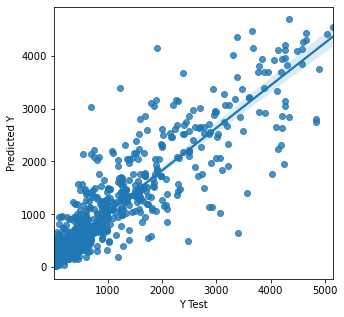

In [ ]:
model = RandomForestRegressor(criterion = 'mse', n_estimators = 100, max_depth = 15, random_state = 42)

model.fit(x_train_prep, y_train)
y_pred = model.predict(x_test_prep)
data = pd.DataFrame({'Actual':y_test, 'Prediction': y_pred})

print(model)
plt.figure(figsize=(5,5))
sns.regplot(y_test,y_pred,fit_reg =True)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()


In [ ]:
df_data = 0

In [ ]:
df_data = x_test
df_data['y_test'] = y_test
df_data['y_pred'] = y_pred

In [ ]:
df_data['error'] = abs(y_pred-y_test)

In [ ]:
df_data

,category,discount_flag,sellable_online,other_colors,designer,depth,height,width,y_test,y_pred,error
483,Bookcases & shelving units,0,True,False,No Designer,51.0,104.0,50.0,200.0,354.835800,154.835800
1221,Chairs,0,True,False,Mia Lagerman,52.0,82.0,52.0,195.0,274.796729,79.796729
2441,Tables & desks,0,True,False,No Designer,3.0,70.0,4.0,25.0,137.937652,112.937652
2151,Sofas & armchairs,0,True,True,No Designer,55.0,83.0,80.0,350.0,283.610234,66.389766
2958,Wardrobes,1,True,False,Ehlén Johansson,50.0,350.0,91.0,750.0,1352.321202,602.321202
...,...,...,...,...,...,...,...,...,...,...,...
355,Bookcases & shelving units,1,True,True,Francis Cayouette,60.0,14.0,38.0,18.0,64.804670,46.804670
2716,TV & media furniture,0,True,True,No Designer,40.0,202.0,60.0,420.0,751.541643,331.541643
2953,Wardrobes,1,True,False,Ehlén Johansson,55.0,216.0,164.0,1245.0,1424.247536,179.247536
1905,Sofas & armchairs,0,True,True,Ola Wihlborg,99.0,83.0,192.0,4190.0,2315.279375,1874.720625


In [ ]:
analyze = df_data.sort_values(by='error', ascending = False)
analyze.head(20)

,category,discount_flag,sellable_online,other_colors,designer,depth,height,width,y_test,y_pred,error
1900,Sofas & armchairs,0,True,True,No Designer,88.0,88.0,80.0,3395.0,656.496423,2738.503577
182,Beds,0,True,False,Ola Wihlborg,140.0,84.0,240.0,695.0,3024.042500,2329.042500
2526,Tables & desks,0,True,True,K Malmvall,280.0,73.0,140.0,4240.0,1942.140833,2297.859167
1396,Chairs,0,True,False,Carina Bengs,110.0,155.0,155.0,4025.0,1765.810774,2259.189226
2160,Sofas & armchairs,0,True,True,Ehlén Johansson,98.0,80.0,235.0,1900.0,4142.637500,2242.637500
2949,Wardrobes,1,True,False,Ehlén Johansson,222.0,350.0,91.0,1226.0,3386.043333,2160.043333
1859,Outdoor furniture,0,True,False,Eva Lilja Löwenhielm,82.0,88.0,144.0,3564.0,1405.559667,2158.440333
2203,Sofas & armchairs,1,True,False,Henrik Preutz,97.0,95.0,160.0,4841.0,2743.628667,2097.371333
2588,Tables & desks,1,True,True,K Malmvall,160.0,55.0,160.0,3064.0,1022.551667,2041.448333
227,Beds,1,True,False,No Designer,97.0,95.0,160.0,4841.0,2803.317500,2037.682500


In [ ]:
analyze.tail(20)

,category,discount_flag,sellable_online,other_colors,designer,depth,height,width,y_test,y_pred,error
2227,Sofas & armchairs,0,True,False,Nike Karlsson,55.0,18.0,80.0,100.0,103.468498,3.468498
623,Bookcases & shelving units,0,True,False,Francis Cayouette,18.0,4.9,4.9,29.0,25.559797,3.440203
955,Cabinets & cupboards,0,True,True,Ebba Strandmark,35.0,3.0,3.0,39.0,42.357423,3.357423
530,Bookcases & shelving units,0,True,True,H Preutz,32.0,5.6,9.0,22.0,25.215318,3.215318
2311,Tables & desks,0,True,True,Tord Björklund,95.0,31.0,95.0,795.0,798.106810,3.106810
462,Bookcases & shelving units,0,True,True,No Designer,37.0,212.0,61.0,695.0,692.617976,2.382024
436,Bookcases & shelving units,0,True,True,H Preutz,24.0,2.1,21.0,27.0,24.719519,2.280481
472,Bookcases & shelving units,0,True,True,Francis Cayouette,2.7,2.7,2.7,22.0,20.043524,1.956476
2609,Tables & desks,0,True,False,No Designer,140.0,65.0,65.0,445.0,443.090833,1.909167
450,Bookcases & shelving units,0,True,False,Francis Cayouette,11.0,1.8,33.0,25.0,23.180148,1.819852


# **Conclusion and Recommendation**

Rekomendasi: Prediksi harga

berdasarkan hasil analisis dan penyusunan model machine learning di atas, maka menurut hemat kami, dapat disampaikan kepada manajemen bahwa strategi penetapan harga produk dapat menggunakan acuan machine learning dengan model regresi berdasarkan pendekatan RandomForestRegressor(criterion = 'mse', n_estimators = 100, max_depth = 15, random_state = 42)

hasil model machine learning tersebut 
R2 sebesar 0.803 artinya seluruh fitur menjelaskan 80,3% terhadap label
tingkat rata-rata eror absolut sebesar 296.761 (MAE)
sedangkan rata-rata akar kuadrat eror sebesar 17.227 (RMSE)

agar dapat memaksimalkan keuntungan, manajemen dapat menggunakan rentang selisih antara harga prediksi dengan harga asli produknya sebagai diskon sehingga pembeli dapat merasa diuntungkan ketika membeli produk IKEA 
